# Saving buffers at predefined time points

In [2]:
#pylab
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pylab import imshow, show

import skimage as sk
from skimage import measure, filters

import matplotlib.pyplot as plt, numpy as np, os
from numba import njit, jit, vectorize
from PIL import Image
import imageio
# import cv2 as cv

if 'nb_dir' not in globals():
    nb_dir = os.getcwd()
from lib.operari import *
from lib.ProgressBar import *
from lib.minimal_model import *
from lib.TexturePlot import *
from lib.get_tips import *
from lib.minimal_model import *
from lib.intersection import *


#TODO: use cuda via numba
# from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
# from lib.contours_to_tips import *

#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
width = 512
height = 512
channel_no = 3

%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


In [3]:
#TODO: list the time points that I'd like to save at.  make a folder to put them in
#TODO: copy the 'generating tips'.  slim it down.  make it's time consistent with the predefined origin
#TODO: edit it to save at those time points (i) buffers and (ii) .png with contours and tips indicated

# def count_tips(x_list):
#     return str(x_list).count('.')

# def find_files(filename, search_path):
#     result = []
#     for root, dir, files in os.walk(search_path):
#         if filename in files:
#             result.append(os.path.join(root, filename))
#     return result
# # def plot_buffer(img_nxt, img_inc, contours_raw, contours_inc, tips, dpi, figsize=(15,15)):
# def plot_buffer(img_nxt, img_inc, contours_raw, contours_inc, tips, figsize=(15,15), max_marker_size=800, lw=2):
#     '''computes display data; returns fig.'''
#     #plot figure
#     fig, ax = plt.subplots(1,figsize=figsize)
#     ax.imshow(img_nxt,cmap='Reds', vmin=0, vmax=1)
#     ax.axis('off')

#     #plot contours, if any.  type 1 = contours_raw (blue), type 2 = contours_inc (green)
#     for n, contour in enumerate(contours_inc):
#         ax.plot(contour[:, 1], contour[:, 0], linewidth=lw, c='g', zorder=2)
#     for n, contour in enumerate(contours_raw):
#         ax.plot(contour[:, 1], contour[:, 0], linewidth=lw, c='b', zorder=2)

#     #plot tips, if any
#     n_values, y_values, x_values = tips
#     #     if len(n_values)>0:
#     for j in range(len(x_values)): 
#         ax.scatter(x = x_values[j], y = y_values[j], c='yellow', s=int(max_marker_size/(j+1)), zorder=3, marker = '*')
#     return fig

# reinitialize with a desired buffer

In [17]:
# data_dir.replace('Data/tip_log_chaos_circle6_','')[:-4]
sigma       = 1
threshold   = 0.95
buffer_fn = f'buffer_time_origin_primed_with_circle6.npy'
# buffer_fn = 'buffer_chaos_circle6_sigma_3_threshold_0.8_wrapping_true_at_time_1800.0.npy'
# buffer_fn   = f'buffer_chaos_circle6_sigma_5_threshold_0.6_wrapping_true_at_time_5400.0.npy'
# save_folder = 'Data/buffers_with_odd_tips_detected'
save_folder = 'Data/buffers_with_odd_tips_detected_ds_5'
time_start  = 0#eval(buffer_fn[buffer_fn.find('time_')+len('time_'):-4])
descrip     = f"chaos_circle6_from_{time_start:.1f}_sigma_{sigma}_threshold_{threshold}_ds_5_"
data_dir    = find_files(buffer_fn,nb_dir)[0]
assert(float(time_start) is not None)

print(f'loading initial buffer from {data_dir}.')
os.chdir(nb_dir)
# txt = np.load(f'Data/buffer_chaos_circle6_sigma_5_threshold_0.6_wrapping_true_at_time_5400.0.npy')
txt = np.load(data_dir)
#reinitialize records
tip_state_lst = []
tme = time_start
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
os.chdir(nb_dir+'/'+save_folder)

loading initial buffer from /Users/timothytyree/Documents/GitHub/care/notebooks/Data/buffer_time_origin_primed_with_circle6.npy.


for channel 0,
	max value: 0.8220734919420856
	min value: -5.842994007759086e-09
	mean value: 0.09040495575159081
	
for channel 1,
	max value: 1.0
	min value: 4.2730396698647395e-07
	mean value: 0.8207531354970061
	
for channel 2,
	max value: 0.9999357315470903
	min value: 0.9255846617243946
	mean value: 0.9930852439857958
	

 number of type 1 contour = 1,	number of type 2 contour = 7,
the number of tips are 0.


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


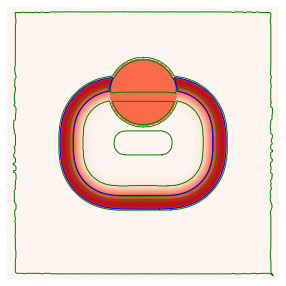

In [18]:
# check all the functions work/ compile the needed functions
describe(txt)
width, height, channel_no = txt.shape
zero_txt = np.zeros((width, height, channel_no), dtype=np.float64)
dtexture_dt = zero_txt.copy()
get_time_step(txt, dtexture_dt)

#calculate contours and tips
img_nxt = txt[..., 0]
img_inc = ifilter(dtexture_dt[..., 0])  #mask of instantaneously increasing voltages 
img_inc = filters.gaussian(img_inc,sigma=sigma, mode='wrap')
contours_raw = measure.find_contours(img_nxt, level=0.5,fully_connected='low',positive_orientation='low')
contours_inc = measure.find_contours(img_inc, level=threshold)#,fully_connected='low',positive_orientation='low')
tips  = get_tips(contours_raw, contours_inc)
n_old = count_tips(tips[1])

#bluf
print(f"\n number of type 1 contour = {len(contours_raw)},\tnumber of type 2 contour = {len(contours_inc)},")
print(f"the number of tips are {n_old}.")
# print(f"""the topological tip state:{tips[0]}""")
# print(f"""x position of tips: {tips[1]}""")
# print(f"""y position of tips: {tips[2]}""")
fig = plot_buffer(img_nxt, img_inc, contours_raw, contours_inc, tips, 
                  figsize=(5,5),max_marker_size=200, lw=1);
fig.show()

In [19]:
# fig.savefig('testsize.pdf', bbox_inches='tight',pad_inches=0)
plt.close()

## run the simulation

In [21]:
recording_times = [2800,2900,3000,3100,3200, 2950, 3050]
np.isclose(3000,recording_times,.01).any()

True

In [24]:
#integrate explicitely in time
timing = False
recording = True
recording_if_odd = True
recording_times = [2800,2900,3000,3100,3200]
h = 0.1
nsteps = int(10**5)
start = time.time()
max_buffers_to_save = 5
buffers_saved = 0
start_saving_buffers_at_step = nsteps/2
tip_states = None
state = np.zeros((512,512,4),dtype=np.float64)
for step in range(nsteps):
    if not recording:
        #integrate explicitely in time
        time_step(txt, h=h, zero_txt=zero_txt) #up to twice as fast as for separated calls
        tme += h
    if recording:
        #calculate discrete flow map
        dtexture_dt = zero_txt.copy()
        get_time_step(txt, dtexture_dt)
        
        #integrate explicitely in time by the forward euler method
        txt += h*dtexture_dt
        tme += h
        
        #compute contours. type 1 = contours_raw, type 2 = contours_inc
        img_nxt = txt[..., 0].copy()
        img_inc = ifilter(dtexture_dt[..., 0])  #mask of instantaneously increasing voltages 
        img_inc = filters.gaussian(img_inc,sigma=sigma, mode='wrap')
        contours_raw = measure.find_contours(img_nxt, level=0.5,fully_connected='low',positive_orientation='low')
        contours_inc = measure.find_contours(img_inc, level=threshold)#,fully_connected='low',positive_orientation='low')

        #compute spiral tips from the corssings 
        tips = get_tips(contours_raw, contours_inc)
        s_lst, x_lst, y_lst = tips
        tip_state_lst.append({
                    't': float(np.around(tme, 1)),
                    'x': tuple(x_lst),
                    'y': tuple(y_lst),
                    's': tuple(s_lst)})
        
        #determine if an odd number of tips were born        
        n = count_tips(x_lst) #counts the number of '.' in the nested list of x positions
        dn = n - n_old
        n_old = n
        
        #save the state if save_state == True as an .npy file
        #save_state = recording_if_odd & odd_event & odd_tip_number # ==> odd birth/death event has just occurred
#         save_state = recording_if_odd & (dn%2!=0) & (n%2!=0)
        save_state = np.isclose(tme,recording_times,.01).any()
        if save_state:
            fig = plot_buffer(img_nxt, img_inc, contours_raw, contours_inc, tips, 
                  figsize=(5,5),max_marker_size=200, lw=1);
            fig.savefig(f'plot_of_n_{n}_dn_{dn}_for_{descrip}_at_time_{tme:.1f}.pdf', bbox_inches='tight',pad_inches=0);
            plt.close();
            if step>start_saving_buffers_at_step:
                if buffers_saved<max_buffers_to_save:
                    buffers_saved += 1
                    np.save(f'buffer_of_n_{n}_dn_{dn}_for_{descrip}_at_time_{tme:.1f}.npy', txt)
    printProgressBar(step + 1, nsteps, prefix = 'Progress:', suffix = 'Complete', length = 50)

#report the bottom line up front
print(f"time integration complete. time elapsed was {time.time()-start:.2f} seconds")
print(f"current time is {tme:.1f}.")
print(f"number of nan pixel voltages is {np.max(sum(np.isnan(txt[...,0])))}.")
print(f"current max voltage is {np.nanmax(txt[...,0]):.4f}.")
print(f"current max fast variable is {np.nanmax(txt[...,1]):.4f}.")
print(f"current max slow variable is {np.nanmax(txt[...,2]):.4f}.")
n_lst, x_lst, y_lst = get_tips(contours_raw, contours_inc)
tip_states = {'n': n_lst, 'x': x_lst, 'y': y_lst}
# print(f"tip_states are {tip_states}.")
# print(f'current tip state is {tip_states}')
# if len(lst)~=0:
# print(f"number of tips is = {set([len(q) for q in lst_x[-1]])}.") #most recent number of tips

if recording:
    tips = get_tips(contours_raw, contours_inc);
    print(f"\n number of type 1 contour = {len(contours_raw)},\tnumber of type 2 contour = {len(contours_inc)},")
    print(f"the number of tips are {count_tips(tips[1])}.")
    #     print(f"""the topological tip state is the following:{tips[0]}""")
beep(3)

/Users/timothytyree/Documents/GitHub/care/notebooks/lib/intersection.py:35: RuntimeWarning: invalid value encountered in less_equal
  C3 = np.less_equal(S5, S6)
/Users/timothytyree/Documents/GitHub/care/notebooks/lib/intersection.py:36: RuntimeWarning: invalid value encountered in greater_equal
  C4 = np.greater_equal(S7, S8)
/Users/timothytyree/Documents/GitHub/care/notebooks/lib/intersection.py:33: RuntimeWarning: invalid value encountered in less_equal
  C1 = np.less_equal(S1, S2)
/Users/timothytyree/Documents/GitHub/care/notebooks/lib/intersection.py:34: RuntimeWarning: invalid value encountered in greater_equal
  C2 = np.greater_equal(S3, S4)


Progress: |██████████████████████████████████████████████████| 100.0% Complete
time integration complete. time elapsed was 6289.69 seconds
current time is 10000.9.
number of nan pixel voltages is 512.
current max voltage is nan.
current max fast variable is 1.0000.
current max slow variable is 1.0000.

 number of type 1 contour = 0,	number of type 2 contour = 0,
the number of tips are 0.


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: All-NaN slice encountered


0

## save tip log

In [25]:
save = True
if save:
    df = pd.DataFrame(tip_state_lst)
    df.to_csv(f'{nb_dir}/Data/tip_log_{descrip}_at_time_{tme:.1f}.csv', index=False)
print('saved to:')
print(f'Data/tip_log__{descrip}_at_time_{tme:.1f}.csv')

saved to:
Data/tip_log__chaos_circle6_from_0.0_sigma_1_threshold_0.95_ds_5__at_time_10000.9.csv


In [26]:
print(f'Data/tip_log__{descrip}_at_time_{tme:.1f}.csv')

Data/tip_log__chaos_circle6_from_0.0_sigma_1_threshold_0.95_ds_5__at_time_10000.9.csv


## save plot of buffer/contours/tips

In [ ]:
# #view/save the buffer with contours and tips plotted
# save = True
# save_file_name = f'buffer_{descrip}_at_time_{tme:.1f}'
# save_dir = f"Figures/{save_file_name}.png"
# image = txt.copy()

# #compute display data
# h = 0.1
# # state = np.zeros((512,512,4),dtype=np.float64)
# # get_tissue_state(texture=txt, out=state[...])
# dtexture_dt = zero_txt.copy()
# get_time_step(txt, dtexture_dt)
# img_nxt = txt[...,0].copy()
# img_inc = txt[...,0].copy()
# #plot figure
# plt.figure(figsize=(15,15))
# plt.imshow(img_nxt,cmap='Reds', vmin=0, vmax=1)
# # plt.title("voltage increases with red", fontsize=24)

# #plot contours, if any.  type 1 = contours_raw, type 2 = contours_inc
# img_inc = ifilter(dtexture_dt[..., 0])  #mask of instantaneously increasing voltages 
# img_inc = filters.gaussian(img_inc,sigma=sigma, mode='wrap')
# contours_raw = measure.find_contours(img_nxt, level=0.5,fully_connected='low',positive_orientation='low')
# contours_inc = measure.find_contours(img_inc, level=threshold,fully_connected='low',positive_orientation='low')
# for n, contour in enumerate(contours_inc):
#     plt.plot(contour[:, 1], contour[:, 0], linewidth=2, c='g', zorder=2)
# for n, contour in enumerate(contours_raw):
#     plt.plot(contour[:, 1], contour[:, 0], linewidth=2, c='b', zorder=2)
# plt.axis('off')

# #plot tips, if any
# tips = get_tips(contours_raw, contours_inc)
# n_values, y_values, x_values = tips
# for j in range(len(tips[2])): #nota bene, tips[2] is x_values
#     plt.scatter(x = tips[2][j], y = tips[1][j], c='yellow', s=int(800/(j+1)), zorder=3, marker = '*')
# print(f"current time is {tme:.1f}")
# print(f"number of type 1 contour = {len(contours_raw)},\tnumber of type 2 contour = {len(contours_inc)},")
# print(f"""the topological tip state is the following: {n_values}""")
# print(f"""x coords: {x_values}""")
# print(f"""y coords: {y_values}""")
# if save:
#     plt.savefig(save_dir)
# #     np.save(f'Data/{save_file_name}.npy', image)
#     print('file saved at')
# #     print(f'Data/{save_file_name}.npy')
# #     np.savez_compressed(f'Data/{save_file_name}.npz', image)
# else:
#     plt.show()